<a href="https://colab.research.google.com/github/illhammm/Sign_preprocessing/blob/ne_provereno/more_clean_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Установка необходимых библиотек*

In [1]:
!pip install pyarrow
!pip install pandas
!pip install opencv-python
!pip install opencv-python
!pip install --upgrade opencv-python

*Импорт библиотек*

In [2]:
import pandas as pd
import pyarrow.parquet as pq
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

*Чтение DataFrame из .pkl файла* (**если файл не найден, загрузка из Google Colab**)

In [3]:
try:
    df = pd.read_pickle('train-00000-of-00001-a16b0610cb895cd7.pkl')
except FileNotFoundError:
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    table = pq.read_table(file_name)
    df = table.to_pandas()
    df.to_pickle('train-00000-of-00001-a16b0610cb895cd7.pkl')

*Вывод информации о DataFrame*

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  504 non-null    int64 
 1   image     504 non-null    object
 2   width     504 non-null    int32 
 3   height    504 non-null    int32 
 4   objects   504 non-null    object
dtypes: int32(2), int64(1), object(2)
memory usage: 15.9+ KB
None


*Вывод первых несколько строк DataFrame*

In [5]:
print(df.head())

   image_id                                              image  width  height  \
0       184  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
1       403  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
2       393  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
3       317  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   
4       304  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640     640   

                                             objects  
0  {'id': [184], 'area': [39601], 'bbox': [[200.0...  
1  {'id': [403], 'area': [81840], 'bbox': [[56.0,...  
2  {'id': [393], 'area': [91178], 'bbox': [[87.0,...  
3  {'id': [317], 'area': [30397], 'bbox': [[237.0...  
4  {'id': [304], 'area': [92757], 'bbox': [[32.0,...  


**Вывод названий всех столбцов в DataFrame**, *чтобы знать название шапки таблицы строки с изображениями*

In [6]:
print(df.columns)

Index(['image_id', 'image', 'width', 'height', 'objects'], dtype='object')


*Узнаем тип данных изображений в столбце*

In [7]:
data_types = df['image'].apply(type).unique()
print(f"Уникальные типы данных во втором столбце: {data_types}")

Уникальные типы данных во втором столбце: [<class 'dict'>]


*Тоже самое по-сути:*

In [8]:
data_type = type(df.iloc[0, 1])
print(f"Тип данных во втором столбце: {data_type}")

Тип данных во втором столбце: <class 'dict'>


*Функция для преобразования словаря с изображением в формат OpenCV*

In [9]:
def convert_dict_to_opencv(dict_image):
    try:
        # Пробуем получить данные изображения по ключу 'b'
        image_bytes = dict_image['b']
    except KeyError:
        try:
            # Если 'b' не сработало, пробуем получить первый доступный ключ
            image_bytes = next(iter(dict_image.values()))
        except StopIteration:
            # Если нет доступных ключей, не удается обработать изображение
            return None

    # Преобразование байтов в массив NumPy
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    # Декодирование изображения с использованием OpenCV
    opencv_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return opencv_image


In [10]:
# Применяем функцию к столбцу image и создаем новую колонку image_opencv

df['image_opencv'] = df['image'].apply(convert_dict_to_opencv)

*Проверим то, что столбец добавился*

In [11]:
print(df.columns)

Index(['image_id', 'image', 'width', 'height', 'objects', 'image_opencv'], dtype='object')


**Функция для отображения изображения из словаря**

*Вызываем функцию для отображения первого изображения в столбце 'image'*

In [12]:
# Выберем первое изображение из столбца 'image'
first_image_dict = df['image'].iloc[0]

In [13]:
# Попробуем получить байтовые данные изображения из словаря
image_bytes = None
for key in first_image_dict.keys():
    if isinstance(first_image_dict[key], bytes):
        image_bytes = first_image_dict[key]
        break

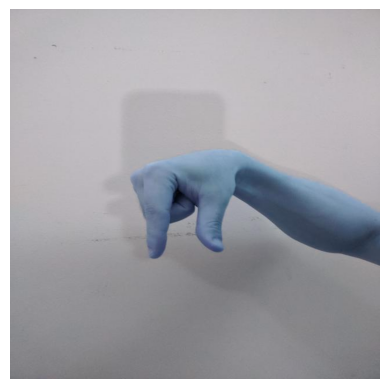

In [14]:
# Если байтовые данные найдены, продолжим обработку
if image_bytes:
    # Преобразуем байты в массив NumPy
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)

    # Декодируем изображение с использованием OpenCV
    opencv_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Отобразим изображение с помощью matplotlib
    plt.imshow(opencv_image)
    plt.axis('off')
    plt.show()
else:
    print("Байтовые данные изображения не найдены в словаре.")

*Функция для проверки наличия **лица** на изображении*




 (Haar Cascade) - для расопзнавания лиц
# инициализируется с помощью cv2.CascadeClassifier
# detectMultiScale для поиска лиц на изображении
Если лица обнаружены, они выделяются на изображении и отображаются с использованием *matplotlib*

In [15]:
def has_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return len(faces) > 0

*Инициализация каскада для распознавания лиц*

In [16]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

Выберем первое изображение из столбца 'image'

In [17]:
first_image_dict = df['image'].iloc[0]

In [18]:
# Попробуем получить байтовые данные изображения из словаря
image_bytes = None
for key in first_image_dict.keys():
    if isinstance(first_image_dict[key], bytes):
        image_bytes = first_image_dict[key]
        break

# Если байтовые данные найдены, продолжим обработку
if image_bytes:
    # Преобразуем байты в массив NumPy
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)

    # Декодируем изображение с использованием OpenCV
    opencv_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Преобразуем изображение в оттенки серого для работы с каскадом
    gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

    # Поиск лиц на изображении
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Если лица найдены, выделим их на изображении
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            cv2.rectangle(opencv_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Отобразим изображение с выделенными лицами
        plt.imshow(cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Лица не обнаружены на изображении.")
else:
    print("Байтовые данные изображения не найдены в словаре.")

Лица не обнаружены на изображении.


**Рассмотрим руки!**

*Инициализация каскада для распознавания рук (# Инициализация каскада для распознавания верхней части тела (включая руки))*

In [19]:
upperbody_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_upperbody.xml')

*Подсчёт количества изображений в столбце 'image', на которых обнаружены руки с использованием Haar-каскада для рук*

In [20]:
# Функция для подсчета изображений с руками
def count_images_with_hands(image_dict):
    # Попробуем получить байтовые данные изображения из словаря
    image_bytes = None
    for key in image_dict.keys():
        if isinstance(image_dict[key], bytes):
            image_bytes = image_dict[key]
            break

    # Если байтовые данные найдены, продолжим обработку
    if image_bytes:
        # Преобразуем байты в массив NumPy
        image_array = np.frombuffer(image_bytes, dtype=np.uint8)

        # Декодируем изображение с использованием OpenCV
        opencv_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        # Преобразуем изображение в оттенки серого для работы с каскадом
        gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

        # Поиск верхних частей тела (включая руки) на изображении
        upperbodies = upperbody_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Если верхние части тела (включая руки) найдены, увеличим счетчик
        if len(upperbodies) > 0:
            return 1
        else:
            return 0
    else:
        # Если байтовые данные изображения не найдены, вернем 0
        return 0

# Подсчет изображений с верхними частями тела (включая руки)
count_hands = df['image'].apply(count_images_with_hands).sum()

In [21]:
print(f"Количество изображений с верхними частями тела (включая руки): {count_hands}")

Количество изображений с верхними частями тела (включая руки): 18


# Инициализация каскада для распознавания руки


In [22]:
hand_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_hand.xml')

!!!*Импортируем некие библиотеки*

In [23]:
import requests
from io import BytesIO
import zipfile
import os

In [24]:
# Загрузка файла каскада для руки
hand_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_hand.xml')

In [25]:
# Заменим 'haarcascade_hand.xml' на вашу скопированную ссылку haarcascade_hand.xml
shared_link = 'haarcascade_hand.xml'


In [26]:
# Получение ID файла из ссылки
file_id = shared_link.split('/')[-1]
file_id = file_id.split('?')[0]

In [27]:
# Формирование прямой ссылки на скачивание файла
download_link = f'https://drive.google.com/uc?id={file_id}'

In [28]:
# Загрузка файла
response = requests.get(download_link)

In [29]:
# Замена 'haarcascade_hand.xml' на фактическое имя вашего файла и укажите путь для сохранения
cascade_path = '/content/haarcascade_hand.xml'

In [30]:
# Сохранение файла
with open(cascade_path, 'wb') as f:
    f.write(response.content)

In [31]:
# Проверка, загружен ли файл
if os.path.isfile(cascade_path):
    print("Файл успешно загружен.")
else:
    print("Ошибка загрузки файла.")

Файл успешно загружен.


In [32]:
# Загрузка каскада для руки
response = requests.get(download_link)
cascade_bytes = response.content
hand_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_hand.xml')
hand_cascade.load(cv2.data.haarcascades + 'haarcascade_hand.xml')

False

In [33]:
# Проверка, загружен ли каскад
if hand_cascade.empty():
    print("Ошибка загрузки каскада.")
else:
    print("Каскад успешно загружен.")

Ошибка загрузки каскада.


In [37]:
# Функция для обработки изображения и подсчета рук
def process_image(image_dict):
    # Попробуем получить байтовые данные изображения из словаря
    image_bytes = None
    for key in image_dict.keys():
        if isinstance(image_dict[key], bytes):
            image_bytes = image_dict[key]
            break

    # Если байтовые данные найдены, продолжим обработку
    if image_bytes:
        # Преобразуем байты в массив NumPy
        image_array = np.frombuffer(image_bytes, dtype=np.uint8)

        # Декодируем изображение с использованием OpenCV
        opencv_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        # Преобразуем изображение в оттенки серого
        gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

        # Поиск руки (или человеческой кисти) на изображении
        hands = hand_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Если рука (или человеческая кисть) найдена, увеличим счетчик и преобразуем изображение в черно-белый формат
        if len(hands) > 0:
            return 1, cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
        else:
            return 0, None
    else:
        # Если байтовые данные изображения не найдены, вернем 0
        return 0, None


In [40]:
# Функция для обработки изображения и подсчета рук
def process_image(image_dict):
    # Попробуем получить байтовые данные изображения из словаря
    image_bytes = None
    for key in image_dict.keys():
        if isinstance(image_dict[key], bytes):
            image_bytes = image_dict[key]
            break

    # Если байтовые данные найдены, продолжим обработку
    if image_bytes:
        # Преобразуем байты в массив NumPy
        image_array = np.frombuffer(image_bytes, dtype=np.uint8)

        # Декодируем изображение с использованием OpenCV
        opencv_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        # Преобразуем изображение в оттенки серого
        gray_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)

        # Проверка, что каскад успешно загружен
        if not hand_cascade.empty():
            # Поиск руки (или человеческой кисти) на изображении
            hands = hand_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Если рука (или человеческая кисть) найдена, увеличим счетчик и преобразуем изображение в черно-белый формат
            if len(hands) > 0:
                return 1, cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
            else:
                return 0, None
        else:
            print("Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.")
            return 0, None
    else:
        # Если байтовые данные изображения не найдены, вернем 0
        return 0, None


In [42]:
# Подсчет и обработка изображений
count_hand_images = 0
for index, row in df.iterrows():
    result, processed_image = process_image(row['image'])
    count_hand_images += result

Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загружен. Убедитесь, что файл каскада верный и доступен.
Каскад для рук не загруже

In [43]:
# Вывод количества изображений с руками
print(f"Количество изображений с руками: {count_hand_images}")

Количество изображений с руками: 0
